<a id="top"></a>
# Tutorial Title

***

## Learning Goals
Write three to five learning goals. A learning goal should describe what a reader should know or be able to do by the end of the tutorial that they didn't know or couldn't do before:

```
By the end of this tutorial, you will:

- Understand how to use aperture photometry to turn a series of two-dimensional
  images into a one-dimensional time series.
- Be able to determine the most useful aperture for photometry on a *Kepler/K2*
  target.
- Create your own light curve for a single quarter/campaign of *Kepler/K2* data.
```

## Introduction
Write a short introduction explaining the purpose of the tutorial. Define any terms or common acronyms that your audience may not know. If you're using some kind of domain-specific astronomical symbol or unusual mathematical concept, make sure you define it (for example, in its mathematical form) and link to any definitions (from literature, Wikipedia, etc.).

If there are background materials or resources that may be useful to the reader to provide additional context, you may link to it here. If your tutorial is a continuation from another tutorial, or there are other tutorials that would be useful for the reader to read before or after your tutorial, mention that here as well.

Finally, under this section you should add a description of the workflow in your notebook. This will essentially be a table of contents outlining the functional cells of the notebook, i.e. the main sections. Each section should link users to the actual section for easier navigation through the notebook. [See here](https://sebastianraschka.com/Articles/2014_ipython_internal_links.html) for how to implement internal links into Jupyter notebooks or follow the example below: 


The workflow for this notebook consists of:
* [Main Content](#main)
* [Loading Data](#loading-data)
* [File and Data Information](#file-info)
* [Visualization](#visualization)
* [Exercises](#exercises)
* [Additional Resources](#resources)

## Imports
Describe the main packages we're using here and their use-case for this notebook. If there's something unusual, explain what the library is, and why we need it.
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data

In [2]:
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from astroquery.mast import Mast
from astroquery.mast import Observations

***

## <a id="main">Main Content</a>

The main content of your tutorial should be subdivided into numbered sections with useful, descriptive headings that make sense based on the content. Break sections up with standard Markdown syntax headings:

```
## Section 1

Intro to Section 1

### Subsection 1a

More detailed info about Section 1

## Section 2

A complete thought that's as important as Section 1 but doesn't need subsections.

```

### <a id="loading-data">Loading Data</a>

Loading data and file information should appear within your main content, at the same time the data is going to be used, if possible. These elements of your tutorial can be their own sections within the main content, but avoid generic or vague headings like “Loading Data” and instead use descriptive headings pertinent to the content of the tutorial and the actual data being downloaded or files being used.

If the user needs to download data to run the tutorial properly, where possible, use [Astroquery](https://astroquery.readthedocs.io/en/latest/) (or similar) to retrieve files. If this is not possible, see the [data guide](https://github.com/spacetelescope/style-guides/blob/master/guides/where-to-put-your-data.md) for other options.

For example, if we wanted to query for data from MAST for Kepler we might do something like:

In [3]:
keplerObs = Observations.query_criteria(target_name='kplr008957091', obs_collection='Kepler')
keplerProds = Observations.get_product_list(keplerObs[0])
yourProd = Observations.filter_products(keplerProds,extension='kplr008957091-2012277125453_lpd-targ.fits.gz',
                                        mrp_only=False)


### <a id="file-info">File and Data Information</a>

Where possible (if the code supports it), use code examples that visually display the data in the tutorial. For example, if you are showing an object such as a Table, display a preview of the table:

In [4]:
yourProd[0:5]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str6,str6,str10,str36,str59,str1,str110,str7,str28,str8,str1,str6,str1,str7,str44,int64,str6,str6,int64
549936,Kepler,timeseries,kplr008957091_lc_Q000000000011111111,Target Pixel Long Cadence (TPL) - Q14,C,mast:KEPLER/url/missions/kepler/target_pixel_files/0089/008957091/kplr008957091-2012277125453_lpd-targ.fits.gz,SCIENCE,Minimum Recommended Products,LPD-TARG,--,Kepler,--,GO30032,kplr008957091-2012277125453_lpd-targ.fits.gz,4365449,549936,PUBLIC,2


In [7]:
# Download the products
output = Observations.download_products(yourProd, mrp_only=False, cache=False)
output

Local Path,Status,Message,URL
str103,str8,object,object
./mastDownload/Kepler/kplr008957091_lc_Q000000000011111111/kplr008957091-2012277125453_lpd-targ.fits.gz,COMPLETE,None,None


Explain pertinent details about the file you've just downloaded. For example, if working with Kepler light curves, explain what's in the different file extensions:

```
- No. 0 (Primary): This HDU contains metadata related to the entire file.
- No. 1 (Light curve): This HDU contains a binary table that holds data like
  flux measurements and times. We will extract information from here when we
  define the parameters for the light curve plot.
- No. 2 (Aperture): This HDU contains the image extension with data collected
  from the aperture. We will also use this to display a bitmask plot that
  visually represents the optimal aperture used to create the SAP_FLUX column in
  HDU1.

```

In [55]:
file = output['Local Path'][0]
print('The HDU list of our output file:')
print(' ')
print(fits.info(file))

data = fits.getdata(file, 1)['FLUX']

The HDU list of our output file:
 
Filename: ./mastDownload/Kepler/kplr008957091_lc_Q000000000011111111/kplr008957091-2012277125453_lpd-targ.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  TARGETTABLES    1 BinTableHDU    287   4757R x 13C   [D, E, J, 64J, 64E, 64E, 64E, 64E, 64E, J, E, E, 40E]   
  2  APERTURE      1 ImageHDU        48   (8, 8)   int32   
None


## <a id="visualization">Visualization</a>

When presenting any visuals and/or plots from the data, make sure you are using color palettes that are color-blind friendly and using language that keeps accessibility in mind. The most common form of color vision deficiency involves differentiating between red and green. Thus, avoiding colormaps with both red and green will avoid many problems in general. Use descriptive keywords not pertaining to the color of the object you are referring to. It is good practice to ensure that your plots and images are large enough to ensure that important details are not hard to see. On the same note, make sure that tick labels, legends, and other plot notations are not too small, and make sure they are descriptive enough that the user can understand what is being represented by the data. 

Let's plot the first four images of the Kepler TPF we just downloaded to see where the center of the PSF is located...

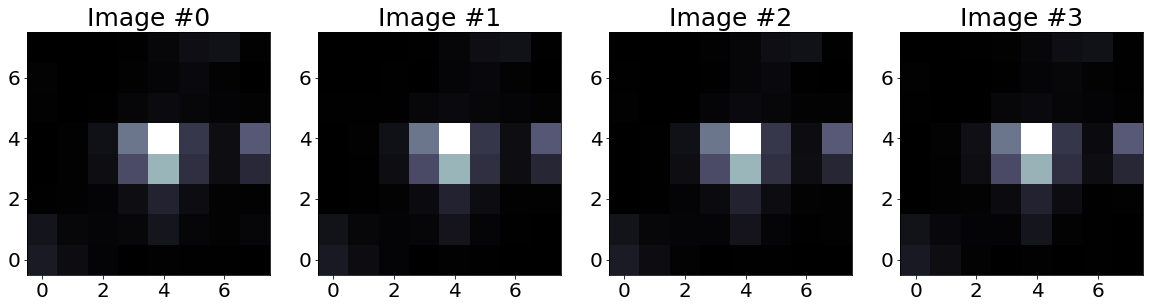

In [80]:
imgs = 4

fig, axs = plt.subplots(1, imgs, figsize=(20, 20))

for idx in range(0, imgs):
    # Plotting
    axs[idx].imshow(data[idx], cmap='bone', origin='lower')
    
    # Formatting
    axs[idx].set_title(f'Image #{idx}', fontsize=25)
    axs[idx].tick_params(axis='both', which='major', labelsize=20)

Looks like it's typically located around (x,y)=(4,4). Let's gather all the images and extract the flux at (4,4) from each of them to patch out lightcurve together...

In [81]:
lightcurve = []

for idx in range(0, len(data)):
    
    flux = data[idx][4, 4]
    lightcurve.append(flux)

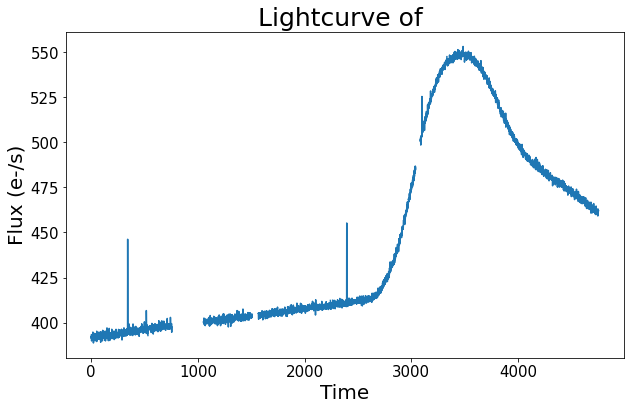

In [93]:
plt.figure(1, figsize=(10, 6))
# Plotting
plt.plot(lightcurve)

# Formatting
plt.title('Lightcurve of ', fontsize=25)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Flux (e-/s)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)

## <a id="exercises">Exercises</a>
Exercises are optional, but encouraged. Exercises can be woven into the main content of your tutorial, or appear in their own section toward the end of the tutorial. Final exercises can be more challenging, similar to homework problems. They can be minimal or take as long as 30 minutes to an hour to complete. If you do have one or more exercises in your tutorial, be sure to leave a blank code cell underneath each to show the reader that they're meant to try out their new skill right there. You may also want to include a "solutions" notebook next to your main notebook for the reader to check their work after they have finished their attempt.

## <a id="resources">Additional Resources</a>

This section is optional. Try to weave resource links into the main content of your tutorial so that they are falling in line with the context of your writing. For resources that do not fit cleanly into your narrative, you may include an additional resources section at the end of your tutorial. Usually a list of links using Markdown bullet list plus link format is appropriate:

- [MAST API](https://mast.stsci.edu/api/v0/index.html)
- [Kepler Archive Page (MAST)](https://archive.stsci.edu/kepler/)
- [Kepler Archive Manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf)
- [Exo.MAST website](https://exo.mast.stsci.edu/)

## About this Notebook
Let the world know who the author of this great tutorial is! If possible and appropriate, include a contact email address for users who might need support (for example, `archive@stsci.edu`). You can also optionally include keywords, your funding source, or a last update date in this section.

**Author:** Jessie Blogs, Archive Scientist.  
**Updated On:** YYYY-MM-DD

## Citations
Provide your reader with guidelines on how to cite open source software and other resources in their own published work.

```
If you use `astropy` or `lightkurve` for published research, please cite the
authors. Follow these links for more information about citing `astropy` and
`lightkurve`:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)

```

***

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 